In [2]:
print(1+1)

2


# 图像增广实现

In [1]:
# 导入相关库
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

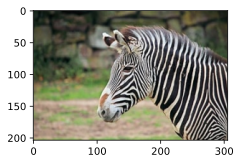

In [2]:
# 显示图片，打开图片并显示
d2l.set_figsize()
img = d2l.Image.open('./th.jpg')
d2l.plt.imshow(img)

In [3]:
# 设置了一个可视化的图像增强函数，利用增强函数处理后，显示出新图像。
# 即结果为显示出8副图像，放大1.5倍的图像
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

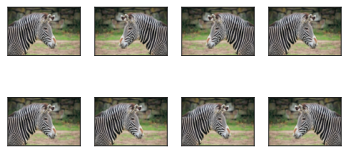

In [4]:
# 给图像使用随机水平翻转操作，50%的概率，agu为左右翻转函数
apply(img, torchvision.transforms.RandomHorizontalFlip())

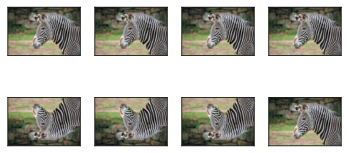

In [5]:
# 给图像使用随机上下翻转操作，50%的概率，agu为上下翻转函数
apply(img, torchvision.transforms.RandomVerticalFlip())

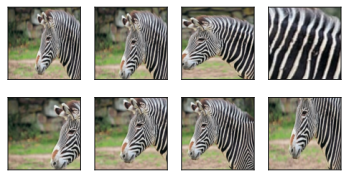

In [6]:
# 随机裁剪操作
# 裁剪后的目标尺寸、裁剪区域相对于原始的比例，裁剪区域宽高比范围
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

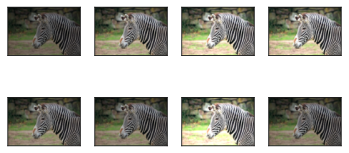

In [7]:
# 改变亮度，范围（50%-150%）
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

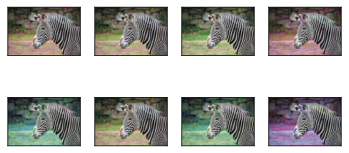

In [8]:
# 改变色调，
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

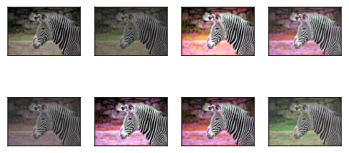

In [9]:
# 改变亮度brightness、对比度contrast，饱和度saturation，色调hue
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

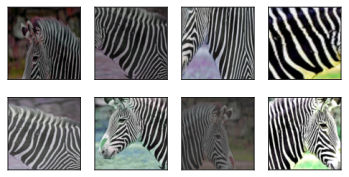

In [10]:
# 图像增强函数汇总，结合多种图像增强方法
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

# 使用图像增广进行训练

100.0%


Extracting ../data\cifar-10-python.tar.gz to ../data


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

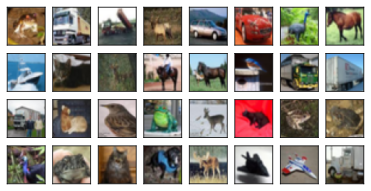

In [12]:
# 下载使用CIFAR10数据集，并显示32个图像，缩放比例为0.8
# 调用第一个参数，图像数据，前32张图像，缩放比例0.8
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [21]:
# 训练集函数：随机左右翻转，深度学习框架张量
# 测试集函数： 深度学习框架张量
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [22]:
# 加载小批量数据集
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
        transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
        shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [23]:
# 多GPU训练
# 判断是否为列表数据
#  神经网络模型设置为训练模式
#  梯度清除为零
#  预测值为神经网络的处理结果
#  计算损失函数
#  损失求和计算，后向传播用于计算梯度
#  更新参数
#  计算准确率等
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [24]:
# 
#创建计时器和优化器长度确定迭代次数、绘制动画图像可视化显示，多个GPU并行运算
# 初始化累加器记录数据，进行训练并计时，数据添加到累加器中，每五个批量技术后动画更新，打印数据
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
        devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
        legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3],
                    None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
            f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
            f'{str(devices)}')

In [25]:
# 定义训练数据的函数
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


IndexError: list index out of range

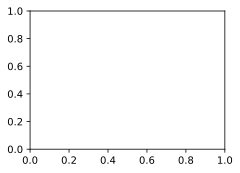

In [26]:
# 进行训练
train_with_data_aug(train_augs, test_augs, net)